In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def sample_ornstein_uhlenbeck(n_timesteps, dt, lambd, m_0=0.0, sigma_0=1.0, sigma_l=1.0, sigma_q=1.0, sub_step=10):
    times = np.zeros(n_timesteps + 1)
    x_T = np.zeros(n_timesteps + 1)
    
    x_0 = m_0 + float(np.random.randn()) * sigma_0 
    
    times[0] = 0
    x_T[0] = x_0
    
    for t in range(1, n_timesteps + 1):
        
        d_dt = dt / sub_step
        x_int = x_T[t - 1]
        
        for _ in range(sub_step):
            eps_t = float(np.random.randn()) * sigma_q * np.sqrt(d_dt)
            dx_t = -lambd * x_int * d_dt + sigma_l * eps_t
            x_int = x_int + dx_t
        
        x_T[t] = x_int
        times[t] = times[t - 1] + dt
    
    return x_T, times

In [17]:
def linear_emission_model(x_T, H=1.0, sigma_r=1.0):
    eps_T = np.random.randn(len(x_T) - 1) * sigma_r
    y_T = H * x_T[1:] + eps_T
    return y_T

In [18]:
def sde_kalman_filter(y_T, dt, m_0=0.0, sigma_0=1.0, lambd=1.0, H=1.0, sigma_l=1.0, sigma_q=1.0, sigma_r=1.0):
    m_prev = m_0
    P_prev = sigma_0 ** 2
    
    m_filter = np.zeros(len(y_T))
    P_filter = np.zeros(len(y_T))
        
    k_var = (sigma_l * sigma_q) ** 2

    for t in range(len(y_T)):
        # Prediction Step
        m_pred = m_prev * float(np.exp(-lambd * dt))
        P_pred = ((-2 * lambd * P_prev + k_var) * float(np.exp(-2 * lambd * dt)) - k_var) / (-2 * lambd)
        
        # Update Step
        v = y_T[t] - H * m_pred
        S = H * H * P_pred + sigma_r ** 2
        K = P_pred * H / S
        
        m_prev = m_pred + K * v
        P_prev = P_pred - K * K * S
        
        m_filter[t] = m_prev
        P_filter[t] = P_prev
    
    return m_filter, P_filter
        
        
        

In [24]:
n_timesteps=1000
dt = 0.01

lambd=1.0

m_0=0.0
sigma_0 = 1.0

sigma_l = 0.5
sigma_q = 1.0

H = 1.0
sigma_r = 1.0

In [25]:
x_T, t_T = sample_ornstein_uhlenbeck(n_timesteps, dt, lambd, m_0, sigma_0, sigma_l, sigma_q)

y_T = linear_emission_model(x_T, H, sigma_r)


m_filter, P_filter = sde_kalman_filter(y_T, dt, m_0, sigma_0, lambd, H, sigma_l, sigma_q, sigma_r)

In [26]:
rms_obs = np.mean((y_T - x_T[1:]) ** 2)
rms_filter = np.mean((m_filter - x_T[1:]) ** 2)
print('RMS of Baseline using Observations: {}'.format(rms_obs))
print('RMS of Kalman Filter: {}'.format(rms_filter))

RMS of Baseline using Observations: 0.950792070324004
RMS of Kalman Filter: 0.04723391612332203


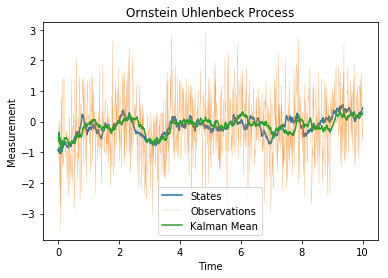

In [27]:
plt.plot(t_T, x_T, label='States')
plt.plot(t_T[1:], y_T, linewidth=0.2, label='Observations')
plt.plot(t_T[1:], m_filter, label='Kalman Mean')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Ornstein Uhlenbeck Process')
plt.legend()

In [29]:
import tqdm
n_rep = 10
rms_b = 0.0
rms_k = 0.0

for _ in tqdm.tqdm(range(n_rep)):
    x_T, t_T = sample_ornstein_uhlenbeck(n_timesteps, dt, lambd, m_0, sigma_0, sigma_l, sigma_q)
    y_T = linear_emission_model(x_T, H, sigma_r)
    m_filter, P_filter = sde_kalman_filter(y_T, dt, m_0, sigma_0, lambd, H, sigma_l, sigma_q, sigma_r)
    rms_b += np.mean((y_T - x_T[1:]) ** 2)
    rms_k += np.mean((m_filter - x_T[1:]) ** 2)

print('Baseline {} Kalman {}'.format(rms_b / n_rep, rms_k / n_rep))

100%|██████████| 10/10 [00:00<00:00, 41.90it/s]

Baseline 1.0073655006790148 Kalman 0.042910455518706446
